<a href="https://colab.research.google.com/github/respect5716/deep-learning-paper-implementation/blob/main/02_Vision/GLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLO

## 0. Info

### Paper
* title: Optimizing the Latent Space of Generative Networks
* author: Piotr Bojanowski et al
* url: https://arxiv.org/abs/1707.05776

### Features
* dataset: celeba

### Reference
* https://github.com/tneumann/minimal_glo
* https://github.com/nathanaelbosch/generative-latent-optimization

## 1. Setup

In [1]:
import os
import easydict
from glob import glob
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

In [2]:
cfg = easydict.EasyDict(
    dataset = 'celeba',

    img_size = 64,
    batch_size = 64,
    num_epoch = 10,

    nz = 100, # latent dim,
    ngf = 64, # generator dim,

    device = 'cuda',
    dataset_dir = '/content/drive/Shareddrives/dataset',
)

## 2. Data

In [3]:
# FROM https://pytorch.org/vision/stable/_modules/torchvision/datasets/folder.html#ImageFolder
IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")

class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.samples = []
        for ext in IMG_EXTENSIONS:
            self.samples += glob(f'{root}/*{ext}')

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        fpath = self.samples[idx]
        img = Image.open(fpath)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, idx

In [ ]:
data_path = os.path.join(cfg.dataset_dir, f'{cfg.dataset}.zip')
!unzip -q "{data_path}" -d 'data'

In [5]:
transform = T.Compose([
    T.Resize(cfg.img_size),
    T.CenterCrop(cfg.img_size),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
dataset = Dataset('/content/data/img_align_celeba', transform)

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True)

In [8]:
data = next(iter(dataloader))
data[0].size(), data[1].size()

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

## 3. Model

In [9]:
# Copied from https://github.com/pytorch/examples/blob/main/dcgan/main.py
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, inputs):
        if len(inputs.size()) == 2:
            inputs = inputs[:, :, None, None]
        return self.main(inputs)

In [10]:
# Do not use for large dataset
def init_by_pca(dataloader, n_components):
    images = []
    for imgs, idxs in dataloader:
        images.append(imgs.view(len(imgs), -1).numpy())
        
    images = np.concatenate(images, axis=0)
    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(images)
    return torch.FloatTensor(Z)


class Latent(nn.Module):
    def __init__(self, ndata, nz):
        super().__init__()
        self.Z = nn.Parameter(torch.randn(ndata, nz))
    
    def forward(self, indices):
        return self.Z[indices]

In [11]:
def gaussian_fn(x, sigma=1.):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - x.mean()) ** 2 ) / (2 * sigma ** 2))

def gaussian_kernel_2d(size=5, sigma=1.):
    grid = np.mgrid[range(size), range(size)] # (2, size, size)
    kernel = gaussian_fn(grid, sigma=sigma)
    kernel = np.prod(kernel, axis=0)
    kernel /= kernel.sum()
    return kernel

def gaussian_smoothing(images):
    num_channel = images.size(1)
    kernel = gaussian_kernel_2d()
    kernel = np.tile(kernel, (num_channel, 1, 1, 1)) # (num_channel, 1, size, size)
    kernel = torch.FloatTensor(kernel).to(images.device)

    _, _, kw, kh = kernel.size()
    images = F.pad(images, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
    images = F.conv2d(images, kernel, groups=num_channel)
    return images

def laplacian_pyramid(img, max_level=5):
    pyramids = []
    curr = img
    for _ in range(max_level):
        filtered = gaussian_smoothing(curr)
        diff = curr - filtered
        pyramids.append(diff)
        curr = F.avg_pool2d(filtered, 2)
    return pyramids

class LaplacianLoss(nn.Module):
    def __init__(self, max_level=5):
        super().__init__()
        self.max_level = max_level
    
    def forward(self, preds, targets):
        preds = laplacian_pyramid(preds, max_level=self.max_level)
        targets = laplacian_pyramid(targets, max_level=self.max_level)
        return sum(F.l1_loss(p, t) for p, t in zip(preds, targets))

## 4. Train

In [12]:
latent = Latent(len(dataset), cfg.nz)

generator = Generator(cfg.nz, cfg.ngf)
generator.apply(weights_init)

_ = latent.to(cfg.device)
_ = generator.to(cfg.device)

In [13]:
params = list(latent.parameters()) + list(generator.parameters())
optimizer = torch.optim.Adam(params)
criterion = LaplacianLoss()

In [14]:
for ep in range(cfg.num_epoch):
    pbar = tqdm(dataloader)
    for inputs, idxs in pbar:
        inputs = inputs.to(cfg.device)
        zs = latent(idxs)
        preds = generator(zs)
        loss = criterion(preds, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        latent.Z.data = latent.Z.data / latent.Z.data.norm(dim=1).max()
        pbar.set_postfix({'loss': loss.item()})

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

  0%|          | 0/3166 [00:00<?, ?it/s]

## 5. Test

### 5.1. From train latent

In [20]:
rand_idxs = len(dataset)
zs = latent.Z[np.random.choice(range(len(dataset)), 16)]
with torch.no_grad():
    outputs = generator(zs)
outputs = outputs.cpu()

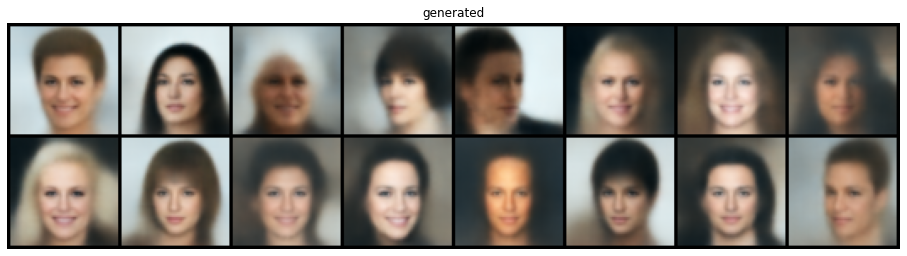

In [21]:
imgs = torchvision.utils.make_grid(outputs, padding=2, normalize=True).permute(1, 2, 0).numpy()
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('generated')
plt.imshow(imgs)
plt.show()

### 5.2. From random latent

In [17]:
zs = torch.randn(16, cfg.nz).to(cfg.device)
with torch.no_grad():
    outputs = generator(zs)
outputs = outputs.cpu()

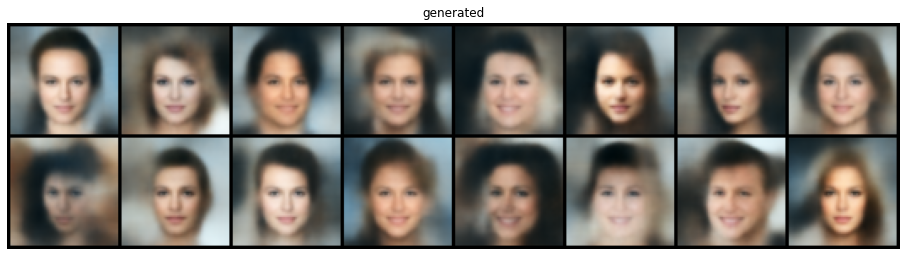

In [19]:
imgs = torchvision.utils.make_grid(outputs, padding=2, normalize=True).permute(1, 2, 0).numpy()
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('generated')
plt.imshow(imgs)
plt.show()